In [37]:
import numpy as np
import sklearn.gaussian_process as gp
from scipy.stats import norm
from scipy.optimize import minimize

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

def my_loss_func(params):
    return -cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()

In [38]:
"""
Bayesian optimization

Chapman's code for a simple bayesian optimization
that works...(hopefully)

This code should be self contained and runs simple example

assumes we are minimizing...
"""

kernel = gp.kernels.Matern()
model = gp.GaussianProcessRegressor(kernel) # can impose covariance structure?

n_rand = 30
n_iters = 20 # want a way to be by iterations or time - while loop?

# obvious solution is x = 0
# place bound on -10, 10
x_dim = 2



In [39]:
loss_function = lambda x: np.sum(np.atleast_2d(x)**2, 1)

# use: my_loss_func
#def loss_function(x):
#    return np.apply_along_axis(my_loss_func, 1, x)

# set up grid

lambdas = np.linspace(-10, 10, 32)
gammas = np.linspace(-10, 10, 22)

def expand_grid(params):    
    from itertools import product
    return np.array(list(product(*params)))

# We need the cartesian combination of these two vectors
param_grid = expand_grid([lambdas, gammas])

real_loss = loss_function(param_grid)
# The maximum is at:
param_grid[np.array(real_loss).argmin(), :]

array([-0.32258065, -0.47619048])

In [40]:
x_start = np.random.uniform(-4.0, 1.0, (5, x_dim))
y_start = loss_function(x_start) # should always assume the function is vectorise, like model.predict

x_all = x_start.copy()
y_all = y_start.copy()


In [41]:

"""
single run...

if x_start is less than 2d -> x_start[:,np.newaxis]
"""

for idx in range(n_iters):
    if idx % 5 == 0 or idx == n_iters-1:
        print(idx)
        #print(y_all[-10:])
    model = model.fit(x_all, y_all)
    
    # calculate expected improvement
    # step 1 generate many many random points
    """
    x_random = np.random.uniform(-10.0, 10.0, (n_rand, x_dim))
    mu, sigma = model.predict(x_random, return_std=True)
    
    # enter some formulas
    loss_optimum = np.min(y_start)
    
    # with np.errstate(divide='ignore')
    gamma_x = (loss_optimum - mu)/sigma
    expected_improvement = sigma*(gamma_x * (norm.cdf(gamma_x)) + norm.pdf(gamma_x))
    """
    def ei(x, gp=model):
        mu, sigma = model.predict(x.reshape(1, -1), return_std=True)
        loss_optimum = np.min(y_start)
        gamma_x = (loss_optimum - mu)/sigma
        return -sigma*(gamma_x * (norm.cdf(gamma_x)) + norm.pdf(gamma_x))

    def get_min(x):
        x = x.reshape(1, -1)    
        return minimize(ei, x0=x, bounds=[(-10.0, 10.0), (-10,10)])

    x_random = np.random.uniform(-10.0, 10.0, (n_rand, x_dim))
    optim_result = np.apply_along_axis(get_min, 1, x_random).flatten()
    all_y = [x.fun[0] for x in optim_result]
    all_x = [x.x for x in optim_result]

    best_y = np.argmin(all_y)
    x_next = all_x[best_y]
    #y_next = all_y[best_y]
    
    # append this one!...
    y_next = loss_function(np.atleast_2d(x_next))
    
    # ...output y_next, x_next
    x_all = np.vstack([x_all, x_next])
    y_all = np.concatenate([y_all, y_next])

0
5
10
15
19


In [42]:
best_point = np.argmin(y_all)
best_x = x_all[best_point]
best_y = y_all[best_point]

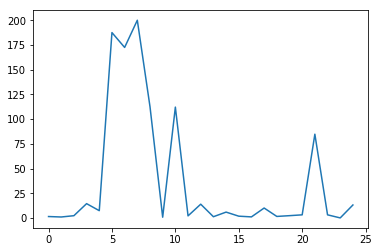

In [43]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.plot(y_all)

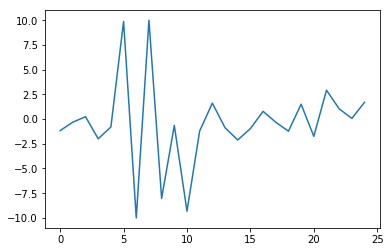

In [44]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.plot(x_all[:, 0])

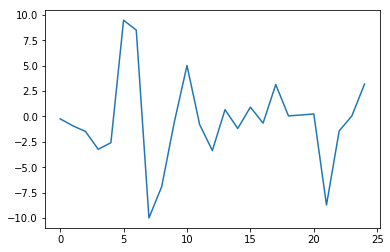

In [45]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.plot(x_all[:, 1])